# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#импорт моделей машинного обучения
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

#импорт метрик
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

#изменение параметров отрисовки
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
#открытие таблиц
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv', parse_dates=True, index_col='date')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates=True, index_col='date')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv',  parse_dates=True, index_col='date')

In [3]:
#расчет MAE для колонки rougher.output.recovery

#подбор необходимых колонок для расчетов
c = gold_recovery_train['rougher.output.concentrate_au']
f = gold_recovery_train['rougher.input.feed_au']
t = gold_recovery_train['rougher.output.tail_au']
recovery = gold_recovery_train['rougher.output.recovery']

#создание DF на основе этих колонок, удаление нулевых значений
data = {'C' : c, 'F' : f, 'T' : t, 'recovery' : recovery}
recovery_df = pd.DataFrame(data=data).query('C > 0 and F > 0 and T > 0')

#удаление пропусков
recovery_df = recovery_df.dropna()

#подсчет эффективности согласно формуле: c*(f-t)/f*(c-t)
recovery_df['recovery_calc'] = ((recovery_df['C'] * (recovery_df['F'] - recovery_df['T'])) / 
                                (recovery_df['F'] * (recovery_df['C'] - recovery_df['T']))) * 100

#вычесление метрики MAE между данными значениями и расчетными
print('Значение MAE между данным и расчетным выходом:', mean_absolute_error(recovery_df['recovery'], recovery_df['recovery_calc']))

Значение MAE между данным и расчетным выходом: 9.661285240080234e-15


#### Вывод

Согласно полученному значению MAE - данные, полученные при расчетах состоятельны, и практически не отличаются от реальных.

In [4]:
#предобработка данных

#удаление строк с отсутствующими значениями целевых признаков
gold_recovery_full = gold_recovery_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])


#создание временных таблиц с удалением показателей состава равных нулю
temp = gold_recovery_full.loc[(gold_recovery_full['final.output.concentrate_ag'] > 0) & 
                              (gold_recovery_full['final.output.concentrate_pb'] > 0) & 
                              (gold_recovery_full['final.output.concentrate_sol'] > 0) & 
                              (gold_recovery_full['final.output.concentrate_au'] > 0)]

temp = temp.loc[(temp['primary_cleaner.output.concentrate_ag'] > 0) & 
                (temp['primary_cleaner.output.concentrate_pb'] > 0) & 
                (temp['primary_cleaner.output.concentrate_sol'] > 0) & 
                (temp['primary_cleaner.output.concentrate_au'] > 0)]

temp = temp.loc[(temp['rougher.output.concentrate_ag'] > 0) & 
                (temp['rougher.output.concentrate_pb'] > 0) & 
                (temp['rougher.output.concentrate_sol'] > 0) & 
                (temp['rougher.output.concentrate_au'] > 0)]

temp = temp.loc[(temp['rougher.input.feed_ag'] > 0) & 
                (temp['rougher.input.feed_pb'] > 0) & 
                (temp['rougher.input.feed_sol'] > 0) & 
                (temp['rougher.input.feed_au'] > 0)]

#заполнение оставшихся пропущенных значений на основании временных меток
pre_processed_full = temp.fillna(method='ffill')

In [5]:
#создание предобработанных таблиц для обучения/теста моделей

#создание списка колонок, необходимых для добавления в обучающую/тестовую таблицы
targets = ['rougher.output.recovery', 'final.output.recovery']
columns_list = gold_recovery_test.columns.tolist()
columns_list.extend(targets)

#создание обучающей/тестовой таблиц на основании предобработанной полной таблицы
#по индексам времени, с удалением пропущенных значений
pre_processed_train = pre_processed_full[columns_list].loc[gold_recovery_train.index].dropna()
pre_processed_test = pre_processed_full[columns_list].loc[gold_recovery_test.index].dropna()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


### Вывод этапа

1) Найдены пропуски в полной/обучающей/тестовой таблицах:
    - Строки, с пропущенными целевыми признаками удалены, т.к. их заполенение скажется на качестве моделей
    - Для строк, характеризующих кол-во веществ в субстрате на разных этапах обработки, составлена логическая индексация.
      Строки, имеющие пропуски всех веществ на одинаковом этапе обработке, удалены.
    - Остальные пропуски заполнены с учетом временных меток методом ffil
    
2) Созданы отдельные таблицы для обучения/теста, согласно их индексу, на основании очищенных данных основной таблицы. Строки, которые ранее имели незаменяемые значения в основной таблице удалены и в малых.
    - В обучающей выборке оставлены только те колонки, которые находятся и в тестовой. В общей таблице колонок больше - это расчетные показатели, которые считают из базовых. Их удаление необходимо, т.к. имея прямую зависимость от базовых, они могут значительно ухудшить результаты модели.

3) Создана отдельная таблица, для расчета эффективности обогащения и сравнения данных значений с реальными. Полученное значением MAE равно 9.661285240080234e-15, т.е. полученные при расчетах данные состоятельны и практически не отличаются от реальных.

# 2. Анализ данных

In [6]:
#измерение концентраций металлов на разных этапах обработки

#создание списков с необходимыми колонками для последующего анализа
ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
      'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']

pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
      'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 
      'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']

#создание списка этапов очистки
xaxisnames = ['rougher input', 'rougher output', 'primary cleaner output', 'final output']


#создание функции для автоматизированной отрисовки графиков
def metal(df, listofcolumns, nameofx, metall):
    data = []
    for i in listofcolumns:
        data.append(df[i].mean())
        
    title = 'Средняя концентрация ' + metall + ' на разных этапах очистки'
    
    fig, ax = plt.subplots()
    width = 0.35
    ax.bar(nameofx, data, width, label='Средняя концентрация')
    ax.set_ylabel('Концентрация')
    ax.set_xticklabels(nameofx, rotation = 45)
    ax.set_title(title)
    plt.show()

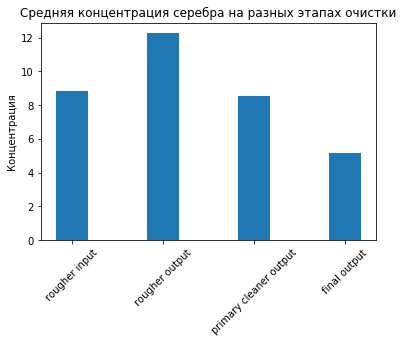

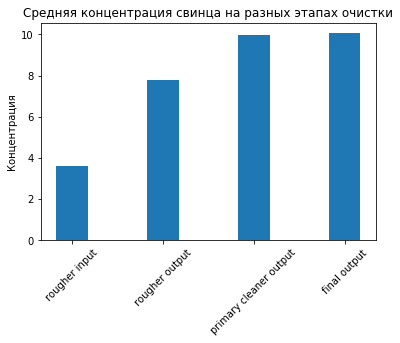

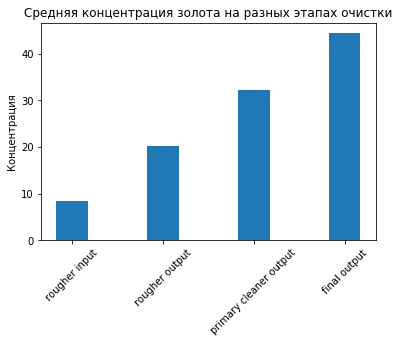

In [7]:
#график концентрации серебра
metal(pre_processed_full, ag, xaxisnames, 'серебра')
#график концентрации свинца  
metal(pre_processed_full, pb, xaxisnames, 'свинца')
#график концентрации золота    
metal(pre_processed_full, au, xaxisnames, 'золота')

#### Вывод

Согласно представленным графикам видно, что содержание необходимого вещества (золота) с каждым этапом обработки увеличивается, в отличие от серебра. Но, вместе с золотом, хоть и не так значительно, увеличивается и концентрация свинца.

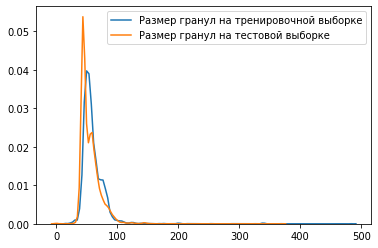

In [8]:
#сравнение распределений размеров гранул сырья на обучающей и тестовой выборках.
sns.kdeplot(data=pre_processed_train['rougher.input.feed_size'], label = 'Размер гранул на тренировочной выборке')
sns.kdeplot(data=pre_processed_test['rougher.input.feed_size'], label = 'Размер гранул на тестовой выборке')

#### Вывод

Распределение размеров гранул сырья обучающей и тестовой выборки очень похоже, что не должно повлиять на качество модели.

In [9]:
#создание списка необходимых колонок, для дальнейшего анализа суммарых концентраций
columns = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au',
          'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
          'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
          'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag',
          'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']

#создание базовой таблицы суммарых концентраций
total_concentrate = pd.DataFrame(pre_processed_full[columns])

#расчет суммарных концентраций
total_concentrate['rougher_input_sum'] = (total_concentrate['rougher.input.feed_ag'] + 
                                          total_concentrate['rougher.input.feed_pb'] +
                                          total_concentrate['rougher.input.feed_sol'] + 
                                          total_concentrate['rougher.input.feed_au'])

total_concentrate['rougher_output_sum'] = (total_concentrate['rougher.output.concentrate_ag'] + 
                                           total_concentrate['rougher.output.concentrate_pb'] +
                                           total_concentrate['rougher.output.concentrate_sol'] +
                                           total_concentrate['rougher.output.concentrate_au'])

total_concentrate['primary_cleaner_sum'] = (total_concentrate['primary_cleaner.output.concentrate_ag'] +
                                            total_concentrate['primary_cleaner.output.concentrate_pb'] +
                                            total_concentrate['primary_cleaner.output.concentrate_sol'] +
                                            total_concentrate['primary_cleaner.output.concentrate_au'])

total_concentrate['rougher_output_sum'] = (total_concentrate['final.output.concentrate_ag'] +
                                           total_concentrate['final.output.concentrate_pb'] +
                                           total_concentrate['final.output.concentrate_sol'] +
                                           total_concentrate['final.output.concentrate_au'])

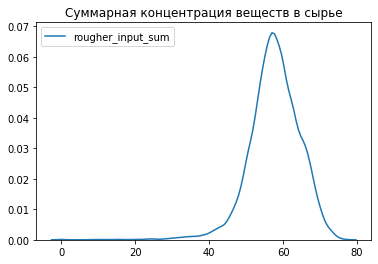

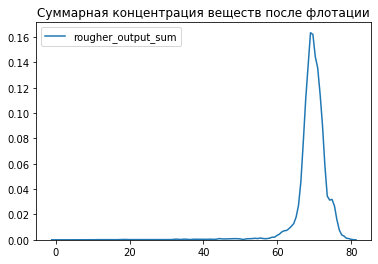

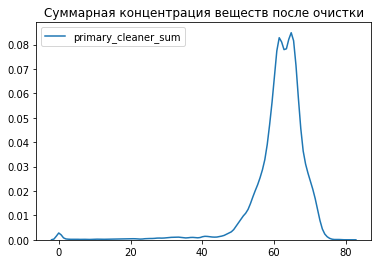

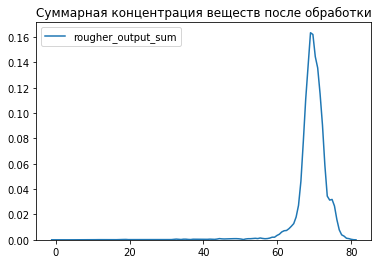

In [10]:
#создание списка колонок для визуализации
columns_to_clean = ['rougher_input_sum', 'rougher_output_sum', 'primary_cleaner_sum', 'rougher_output_sum']

#создание списка ярлыков
labels = ['Суммарная концентрация веществ в сырье', 'Суммарная концентрация веществ после флотации',
         'Суммарная концентрация веществ после очистки', 'Суммарная концентрация веществ после обработки']

#отрисовка графиков суммарных концентраций
for i in range(len(columns_to_clean)):
    sns.kdeplot(data=total_concentrate[columns_to_clean[i]]).set_title(labels[i])
    plt.show()

#### Вывод

Согласно приведенным выше графикам, большинство показателей не имеют значительных выбросов. Но, учитывая пик около нуля, следует удалить пограничные значения. За границу будет представлена суммарная концентрация веществ - менее 1.

In [11]:
#создание списка колонок для последующей очистки
columns_to_clean = ['rougher_input_sum', 'rougher_output_sum', 'primary_cleaner_sum', 'rougher_output_sum']

#очистка обучающей и тестовой выборок
for i in columns_to_clean:
    pre_processed_train = pre_processed_train.loc[total_concentrate[i] > 1]
    pre_processed_test = pre_processed_test.loc[total_concentrate[i] > 1]

### Вывод этапа

1) Проанализировано измерение концентраций металлов на разных этапах обработки:
    - Количество золота и свинца с каждым этапом очистки растет
    - Количество серебра с каждым этапом очистки падает
    
   Суммарное повышение концентрации золота и свинца с каждым этапом очистки возможно связано с тем, что это элементы шестого периода (79 и 82 атомный номер соответственно). Для дальнейшего понимания следует подробнее изучить процесс очистки и физико-химические св-ва данных элементов
   
2) Произведено сравнение распределение размеров гранул сырья обучающей и тестовой выборок. Данные распределения похожи, что не будет сказываться на качестве модели.

3) Произведен анализ выбросов для суммарных концентраций веществ на разных этапах очистки. Наблюдаются единичные пики около ноля. Принято решение удалить все значения веществ меньше 1.
    - Возможно такие пики связаны с калибровкой оборудования или с неисправностью.

# 3. Модель

In [12]:
#создание функции для вычисления метрик sMAPE и final sMAPE
def smape(y_true, y_pred):
    return  np.sum(np.abs(y_true - y_pred) / (((np.abs(y_true) + np.abs(y_pred))) / 2)) * 100 /len(y_true)

def final_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher + 0.75*smape_final

In [13]:
#обработка обучающей выборки
to_train = pre_processed_train.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
rougher_train = pre_processed_train['rougher.output.recovery']
final_train = pre_processed_train['final.output.recovery']

#обработка тостовой выборки
to_test = pre_processed_test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
rougher_test = pre_processed_test['rougher.output.recovery']
final_test = pre_processed_test['final.output.recovery']

#создание пользовательской метрики (sMAPE)
smape_score = make_scorer(smape, greater_is_better=False)

#создание моделей для оценки их эффективности
model_dtr = DecisionTreeRegressor()
model_rfr = RandomForestRegressor(n_estimators=20)
model_lr = LinearRegression()

#создание "глупой" модели для оценки адекватности основных
dummy_regr = DummyRegressor(strategy="median")

In [15]:
#обучение моделей дерева решений и проверка кросс-валидацией
rough_dtr = cross_val_score(model_dtr, to_train, rougher_train, scoring=smape_score, cv=5)
final_dtr = cross_val_score(model_dtr, to_train, final_train, scoring=smape_score, cv=5)
print("sMAPE rougher обучающей выборки для модели DTR:", rough_dtr.mean())
print("sMAPE final обучающей выборки для модели DTR:", final_dtr.mean())
print("Итоговый sMAPE обучающей выборки для модели DTR:", final_smape(rough_dtr.mean(), final_dtr.mean()))

sMAPE rougher обучающей выборки для модели DTR: -9.757523405170968
sMAPE final обучающей выборки для модели DTR: -13.81362816421219
Итоговый sMAPE обучающей выборки для модели DTR: -12.799601974451885


In [16]:
#обучение моделей случайного леса и проверка кросс-валидацией
rough_rfr = cross_val_score(model_rfr, to_train, rougher_train, scoring=smape_score, cv=5)
final_rfr = cross_val_score(model_rfr, to_train, final_train, scoring=smape_score, cv=5)
print("sMAPE rougher обучающей выборки для модели RFR:", rough_rfr.mean())
print("sMAPE final обучающей выборки для модели RFR:", final_rfr.mean())
print("Итоговый sMAPE обучающей выборки для модели RFR:", final_smape(rough_rfr.mean(), final_rfr.mean()))

sMAPE rougher обучающей выборки для модели RFR: -8.20108373192424
sMAPE final обучающей выборки для модели RFR: -8.893379922961058
Итоговый sMAPE обучающей выборки для модели RFR: -8.720305875201852


In [17]:
#обучение моделей линейной регрессии и проверка кросс-валидацией
rough_lr = cross_val_score(model_lr, to_train, rougher_train, scoring=smape_score, cv=5)
final_lr = cross_val_score(model_lr, to_train, final_train, scoring=smape_score, cv=5)
print("sMAPE rougher обучающей выборки для модели LR:", rough_lr.mean())
print("sMAPE final обучающей выборки для модели LR:", final_lr.mean())
print("Итоговый sMAPE обучающей выборки для модели LR:", final_smape(rough_lr.mean(), final_lr.mean()))

sMAPE rougher обучающей выборки для модели LR: -7.021392405240535
sMAPE final обучающей выборки для модели LR: -10.199646176127526
Итоговый sMAPE обучающей выборки для модели LR: -9.405082733405779


In [18]:
#обучение "глупых" моделей для сравнений
rough_dummy = cross_val_score(dummy_regr, to_train, rougher_train, scoring=smape_score, cv=5)
final_dummy = cross_val_score(dummy_regr, to_train, final_train, scoring=smape_score, cv=5)
print("sMAPE rougher обучающей выборки для модели dummy:", rough_dummy.mean())
print("sMAPE final обучающей выборки для модели dummy:", final_dummy.mean())
print("Итоговый sMAPE обучающей выборки для модели dummy:", final_smape(rough_dummy.mean(), final_dummy.mean()))

sMAPE rougher обучающей выборки для модели dummy: -7.47526810104844
sMAPE final обучающей выборки для модели dummy: -9.564129479481936
Итоговый sMAPE обучающей выборки для модели dummy: -9.041914134873563


#### Вывод

Согласно полученным результатам, наиболее эффективной моделью является модель "случайного леса" с характеристиками:
    - sMAPE rougher: 8.2
    - sMAPE final: 8.9
    - Итоговый sMAPE: 8.7
    
Характеристики глупой модели:
    - sMAPE rougher: 7.4
    - sMAPE final: 9.6
    - Итоговый sMAPE: 9.0

По итогам сравнения - обученная модель "случайного леса" является адекватной.

In [20]:
#обучение финальных моделей случайного леса и проверка на тестовой выборке
model_rfr_rough = RandomForestRegressor(n_estimators=20)
model_rfr_final = RandomForestRegressor(n_estimators=20)

rough_rfr_test = cross_val_score(model_rfr_rough, to_test, rougher_test, scoring=smape_score, cv=5)
final_rfr_test = cross_val_score(model_rfr_final, to_test, final_test, scoring=smape_score, cv=5)

print("sMAPE rougher тестовой выборки для модели RFR:", rough_rfr_test.mean())
print("sMAPE final тестовой выборки для модели RFR:", final_rfr_test.mean())
print("Итоговый sMAPE тестовой выборки для модели RFR:", final_smape(rough_rfr_test.mean(), final_rfr_test.mean()))

sMAPE rougher тестовой выборки для модели RFR: -4.434862037010051
sMAPE final тестовой выборки для модели RFR: -8.58287192894681
Итоговый sMAPE тестовой выборки для модели RFR: -7.54586945596262


## Общий вывод

### Произведены следующие этапы работ:

1) **Подготовка данных:**
    - Удалены незаполняемые пропуски в данных, оставшиеся заменены согласно временным меткам.
    - Созданы отдельные таблицы для обучения/теста, согласно их индексу, на основании очищенных данных основной таблицы.
    - Согласно проверке (вычесление MAE), целевые признаки, полученные на практике, практически не отличаются от вычисленных.
        
2) **Анализ данных:**
    - Проанализированы концентрации металлов на разных этапах очистки:
        * Увеличение концентрации золота и свинца с каждым последующим этапом очистки.
        * Уменьшение концентрации серебра с каждым последующим этапом очистки.
    - Проанализированы распределения размеров гранул сырья на обучающей и тестовой выборках, сильных различий не выявлено.
    - Проанализированы суммарные концентрации веществ на разных этапах очистки. Удалены пики близ нуля с верхней границей суммарной концентрации - 1.
    
3) **Построены модели:**
    - Выполнено обучение нескольких моделей (дерева решений, "случайного леса", линейной регрессии). Наилучший результат достигнут с помощью модели "случайного леса".
        * Данная модель была сравнена с обученной "глупой" моделью:
            > Для "случайного леса": sMAPE rougher: 8.2; sMAPE final: 8.9; Итоговый sMAPE: 8.7;
            > Для "глупой" модели: sMAPE rougher: 7.4; sMAPE final: 9.6; Итоговый sMAPE: 9.0;
          Т.е. модель прошла проверку на адекватность.
    - Модель успешно прошла проверку на тестовой выборке:
        * sMAPE rougher тестовой выборки для модели RFR: 4.4
        * sMAPE final тестовой выборки для модели RFR: 8.5
        * Итоговый sMAPE тестовой выборки для модели RFR: 7.5

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке